In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import mglearn

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
# 차트의 한글 깨짐 방지를 위한 코드 추가

from matplotlib import font_manager, rc
import platform

# 그래프에서 한글 표기를 위한 글꼴 변경(윈도우)
font_path = ''
font_path = 'c:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname = font_path).get_name()
rc('font',family = font_name)

%matplotlib inline

# 그리드 서치
매개변수를 튜닝하는 방법

다음 예시들은 RBF 커널 SVM을 사용<br>
매개변수로는 커널의 폭에 해당하는 gamma와 규제 매개변수 C가 있음<br>
C와 gamma에 0.001~100까지 로그스케일(6개)로 값을 적용할 것인데 모든 조합은 36가지이다.

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

In [6]:
iris = load_iris()

In [7]:
X_train,X_test,y_train,y_test = train_test_split(iris.data,iris.target,random_state=0)

In [9]:
print(X_train.shape,X_test.shape)

(112, 4) (38, 4)


In [17]:
import time
start_time = time.time()
best_score = 0
para = [0.001,0.01,0.1,1,10,100]
for gamma in para:
    for C in para:
        svm = SVC(gamma=gamma,C=C)
        svm.fit(X_train,y_train)
        score = svm.score(X_test,y_test)
        if score > best_score:
            best_score = score
            best_parameters = {'C':C,'gamma':gamma}
print(best_score)
print(best_parameters)
print("걸린시간 : ",time.time() - start_time)

0.9736842105263158
{'C': 100, 'gamma': 0.001}
걸린시간 :  0.04485058784484863


## 매개변수의 과대적합과 검증세트
0.97의 정확도를 보이지만 새로운 데이터에는 이 정확도가 이어지지 않을 수 있다. 매개변수를 조정하기 위해 테스트세트를 이미 사용했기 때문에 모델이 얼마나 좋은지 평가하는데는 더 이상 사용할 수 없다.<br>
즉, 평가를 위해서는 모델을 만들때 사용하지 않은 독립된 데이터셋이 필요하다.

데이터셋을 세개로 나눠 훈련세트로는 모델을 만들고, 검증 세트로는 모델의 매개변수를 선택했고, 테스트세트로는 선택된 매개변수의 성능을 평가한다.

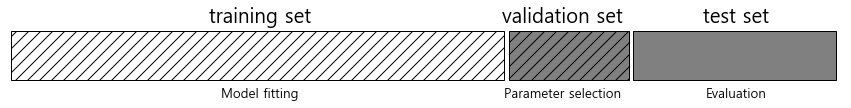

In [18]:
mglearn.plots.plot_threefold_split()

In [19]:
# 해당 코드

X_trainval,X_test,y_trainval,y_test = train_test_split(
iris.data,iris.target, random_state=0)

# 훈련세트와 검증세트로 분할
X_train,X_valid,y_train,y_valid = train_test_split(X_trainval,y_trainval,random_state=1)

print(X_train.shape,X_valid.shape,X_test.shape)

(84, 4) (28, 4) (38, 4)


In [23]:
start_time = time.time()

best_score = 0

for gamma in para:
    for C in para:
        svm = SVC(gamma=gamma,C=C)
        svm.fit(X_train,y_train)
        score = svm.score(X_valid,y_valid)
        if score > best_score:
            best_score = score
            best_parameters = {'C':C,'gamma':gamma}
svm = SVC(**best_parameters)
svm.fit(X_trainval,y_trainval)
test_score = svm.score(X_test,y_test)
print("최고 점수 : ",best_score)
print("최고 파라미터 : ",best_parameters)
print("해당 파라미터에서 테스트셋 점수 : ",test_score)
print("걸린 시간 : ",time.time() - start_time)

최고 점수 :  0.9642857142857143
최고 파라미터 :  {'C': 10, 'gamma': 0.001}
해당 파라미터에서 테스트셋 점수 :  0.9210526315789473
걸린 시간 :  0.03886771202087402


검증 세트에서의 정확도가 낮아진 이유는 학습시의 데이터가 줄어들었기 때문. 하지만 테스트 세트에서의 점수는 훨씬 낮은 0.92<br>
앞에서 예상한 0.97이 아니다.

훈련세트, 검증세트, 테스트세트의 구분은 실제 머신러닝 알고리즘에 매우 중요<br>
테스트세트 정확도에 기초해 어떤 선택을 한다면 모델에 테스트세트 정보를 누설한 것이 된다. <br>
### 그렇기 때문에 최종 평가에만 사용하도록 테스트 세트를 분리해 유지하는 것이 중요하다.

## 교차 검증을 위한 그리드 서치
일반화 성능을 더 좋게 하기 위해서는 훈련 세트와 검증 세트를 한번만 나누지 않고 교차 검증을 사용해 각 매개변수 조합의 성능을 평가할 수 있다.

In [24]:
from sklearn.model_selection import cross_val_score

In [27]:
start_time = time.time()
best_score = 0
for gamma in para:
    for C in para:
        svm = SVC(gamma=gamma,C=C)
        scores = cross_val_score(svm,X_trainval,y_trainval,cv=5)
        score = np.mean(scores)
        if score > best_score:
            best_score = score
            best_para = {'C':C,'gamma':gamma}
svm = SVC(**best_para)
svm.fit(X_trainval,y_trainval)
print("걸린 시간 : ",time.time()-start_time)

걸린 시간 :  0.20581388473510742


교차검증을 위해 파라미터 조합 36 * 5번의 실행 = 총 180개의 모델을 만들어야하기 때문에 시간이 매우 오래 걸린다.

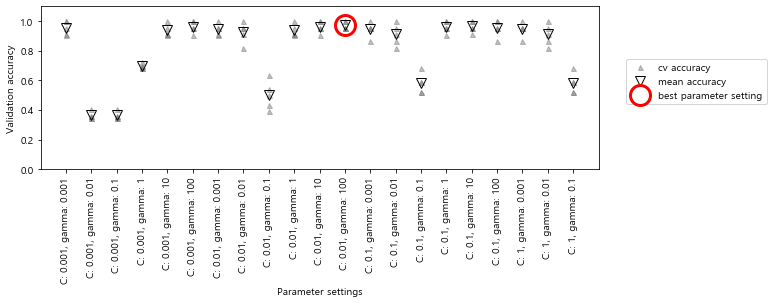

In [28]:
mglearn.plots.plot_cross_val_selection()

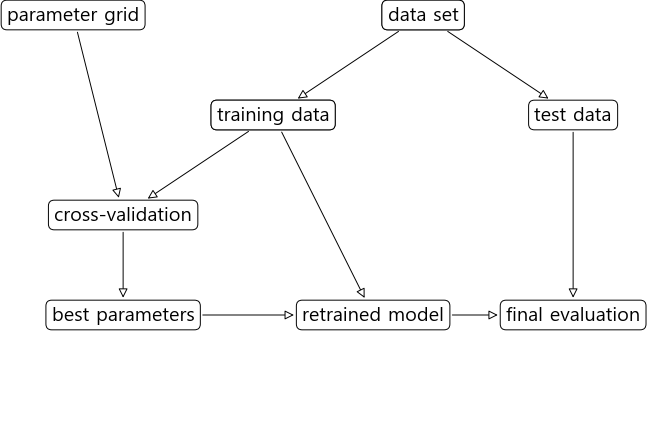

In [29]:
# 그리드 서치를 적용하여 최종 매개변수를 평가하는 전체 과정

mglearn.plots.plot_grid_search_overview()

In [30]:
# 그리드 서치 사용을 위해서는 다음과 같은 딕셔너리가 필요

param_grid = {'C':[0.001,0.01,0.1,1,10,100],'gamma':[0.001,0.01,0.1,1,10,100]}


In [43]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(SVC(),param_grid,cv=5,return_train_score=True)

그리드 서치는 교차 검증을 사용. 그러나 과대적합 되는 것을 피하기 위해서는 여기서도 훈련세트와 테스트세트로 나눌 필요가 있음<br>

그리드 서치도 분류에는 stratifiedKFold, 회귀에는 KFold를 기본값으로 사용

In [38]:
X_train,X_test,y_train,y_test = train_test_split(iris.data,iris.target,random_state=0)

grid_search 객체는 분류기와 비슷해서 fit,predict,score 메서드를 제공한다. <br>하지만 fit 메서드를 호출하려면 param_grid에 설정된 매개변수 조합에 대한 교차 검증을 수행한다.

In [44]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

GridSearchCV 객체의 fit 메서드는 최적의 매개변수를 찾는 일뿐 아니라, 교차 검증 성능이 가장 좋은 매개변수로 전체 훈련 데이터셋에 대해 새로운 모델을 자동으로 만든다.

In [45]:
grid_search.score(X_test,y_test)

0.9736842105263158

In [46]:
grid_search.best_params_

{'C': 10, 'gamma': 0.1}

In [47]:
# 위의 score는 전체 훈련세트에서 학습한 모델에 대한 것. 
# best_score_속성에는 훈련 세트에서 수행한 최상의 교차 검증의 평균 정확도가 저장
grid_search.best_score_

0.9731225296442687

In [48]:
grid_search.best_estimator_

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## 교차 검증 결과 분석
그리드 서치는 연산비용이 매우 크므로 비교적 간격을 넓게 하여 비교적 적은 그리드로 시작하는 것이 좋음. <br>
그런 다음 교차 검증된 그리드 서치의 결과를 분석하여 검색을 확장할 수 있다.

grid_search.cv_results_는 수행 횟수들에 대해 많은 정보를 담고 있는 사전이므로 DataFrame으로 시각화하여 살펴볼 수 있다.

In [49]:
result = pd.DataFrame(grid_search.cv_results_)
np.transpose(result.head())

,0,1,2,3,4
mean_fit_time,0.000779867,0.000402784,0.00125403,0.00100694,0.000796175
std_fit_time,0.000391177,0.000493372,0.000437221,2.13278e-05,0.000398138
mean_score_time,0.00060606,0.000611544,0.000769615,0.00018363,0.000397491
std_score_time,0.00049514,0.000500393,0.000388008,0.00036726,0.000486833
param_C,0.001,0.001,0.001,0.001,0.001
param_gamma,0.001,0.01,0.1,1,10
params,"{'C': 0.001, 'gamma': 0.001}","{'C': 0.001, 'gamma': 0.01}","{'C': 0.001, 'gamma': 0.1}","{'C': 0.001, 'gamma': 1}","{'C': 0.001, 'gamma': 10}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826
split2_test_score,0.363636,0.363636,0.363636,0.363636,0.363636


검색 대상 매개변수 그리드가 2차원이므로(C와 gamma), 히트맵으로 시각화하기가 좋다. 

먼저 교차 검증의 평균을 뽑아 C,gamma 축에 맞도록 배열 차원을 바꾼다.

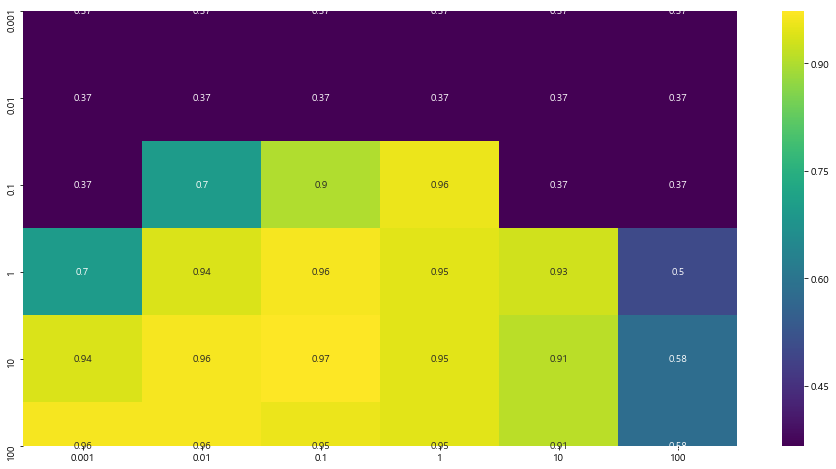

In [77]:
scores = np.array(result.mean_test_score).reshape(6,6)
import seaborn as sns
plt.figure(figsize=(16,8))
sns.heatmap(scores,xticklabels = param_grid['gamma'],yticklabels = param_grid['C'],cmap='viridis',annot=True)

SVC는 매개변수 설정에 매우 민감하다,

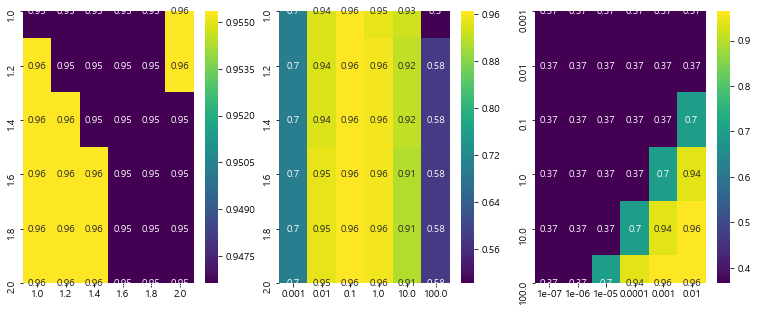

In [81]:
fig,axes = plt.subplots(1,3,figsize=(13,5))
param_grid_linear = {'C':np.linspace(1,2,6),
                    'gamma':np.linspace(1,2,6)}
param_grid_one_log = {'C':np.linspace(1,2,6),
                     'gamma':np.logspace(-3,2,6)}
param_grid_range = {'C':np.logspace(-3,2,6),
                   'gamma':np.logspace(-7,-2,6)}
for param_grid, ax in zip([param_grid_linear, param_grid_one_log,param_grid_range],axes):
    grid_search = GridSearchCV(SVC(),param_grid,cv=5)
    grid_search.fit(X_train,y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6,6)
    
    scores_image = sns.heatmap(scores,xticklabels = param_grid['gamma'],yticklabels = param_grid['C'],
                               cmap='viridis',annot=True,ax=ax)

첫 번째 그래프는 점수변화가 거의 없어 색의 변화 역시 얼마 없음. 이런 결과는 C와 gamma의 스케일과 범위가 부적절할 때 발생,<br>
그러나 매개변수 설정이 바뀌어도 정확도에 아무 변화가 없다면, 그 매개변수가 전혀 중요하지 않은 것일 수도 있다.<br>
처음에는 극잔적인 값을 적용해보고, 매개변수를 바꿔가며 정확도가 변하는지 살펴보는 것이 좋다

두 번째 그래프는 세로 띠 형태. 이는 gamma 매개변수만 정확도에 영향을 준다는 뜻이다.<br>
즉 gamma는 적절한 범위를 탐색하고 있지만 C는 그렇지 못하다던지 아니면 중요 매개변수가 아니라던지 하는 뜻이다.

세 번째 그래프는 C와 gamma 둘 모두에 따라 값이 변했으나 왼쪽 위에서 아무 변화가 없었으니 <br>
다음 번 검색 때는 매개변수 그리드에서 매우 작은 단위는 제외될 것.<br>
최적의 그래프가 경계에 있으니 이 경계 너머에 더 나은 값이 있을 것이라 추측이 가능하다.

최종 테스트 세트를 대상으로 여러 매개변수 범위를 테스트해서는 안된다. 테스트 세트 평가는 사용할 모델이 정확히 결정되고 딱 한번만 해야한다.

## 비대칭 매개변수 그리드 탐색
어떤 경우에는 모든 매개변수 조합에 대해 GridSearchCV를 수행하는 것은 좋지 않을 수 있다. 예를 들어 SVC는 kernel 매개변수를 가지고 있는데,<br> 어떤 커널을 사용하는지에 따라 관련있는 매개변수들이 결정된다. kernel='linear'이면 선형모델이고 C만 사용, kernel='rbf'이면 C와 gamma 모두를 사용한다. (degree는 사용하지 않는다.) <br>이런 경우 C,gamma,kernel 매개변수의 모든 조합을 조사하는 것은 맞지 않는다. kernel='linear'이면 gamma를 사용하지 않으므로 gamma에 대해 조사하는 것은 시간 낭비이다. 이런 조건부 매개변수 조합을 적용하려면 GridSearchCV에 전달할 param_grid를 딕셔너리의 리스트로 만들어주면 된다.

In [84]:
# 그리드서치의 파라미터 변수는 사전이나 사전을 포함한 리스트인데 사전은 조합을 이루는 단위이며, 다른 사전끼리는 조합하지 않는다.
param_grid = [{'kernel':['rbf'],'C':para,'gamma':para},
             {'kernel':['linear'],'C':para}]

In [87]:
grid_search = GridSearchCV(SVC(),param_grid,cv=5,return_train_score=True)
grid_search.fit(X_train,y_train)
print(grid_search.best_params_,'\n',grid_search.best_score_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'} 
 0.9731225296442687


In [88]:
result = pd.DataFrame(grid_search.cv_results_)
result.T

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.000822067,0.000778723,0.000398731,0.000613737,0.000850058,0.000820494,0.000598192,0.000210857,0.00060401,0.000368929,...,0,0,0,0,0,0,0,0,0,0
std_fit_time,0.000412505,0.000391072,0.000488344,0.000501826,0.000427476,0.000412147,0.000489548,0.000421715,0.000493213,0.000451853,...,0,0,0,0,0,0,0,0,0,0
mean_score_time,0.000377226,0.000199413,0,0.000383329,0.000377464,0,0,0.000194693,0.000413036,0.000403261,...,0,0,0,0,0,0,0,0,0,0
std_score_time,0.000463345,0.000398827,0,0.000470096,0.000463232,0,0,0.000389385,0.000506941,0.000495611,...,0,0,0,0,0,0,0,0,0,0
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,1,0.956522,0.869565,0.521739,0.347826,0.869565,1,1,1,0.956522
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,...,0.956522,0.956522,0.913043,0.521739,0.347826,0.869565,0.913043,0.956522,1,0.956522


## 그리드 서치에 다양한 교차 검증 적용
cross_val_score과 비슷하게, GridSearchCV는 분류에는 기본적으로 계층형 k-겹 교차 검증을 사용하고, 회귀에는 k-겹 교차 검증을 사용한다.<br>
그러나 GridSearchCV의 cv 매개변수는 다른 교차 검증 분할기를 사용할 수도 있다.<br>
데이터셋이 매우 크거나 모델 구축에 시간이 오래 걸릴 경우 n_splits=1로 하고 ShuffleSplit, StratifiedShuffleSplit을 사용한다.

## 중첩 교차 검증(nested cross-validation)
GridSearchCV를 사용할 때 여전히 훈련세트와 테스트세트를 한 번만 나누기 때문에, 결과가 불안정하고 테스트 데이터의 분할 방식에 의존한다.<br>
원본 데이터를 훈련, 테스트 세트로 한번만 나누는 방식 대신 더 나아가 교차 검증 분할 방식을 사용할 수 있는데 이를 '중첩 교차 검증'이라고 한다.

미래의 데이터에 적용하기 위한 예측 모델을 찾는데는 거의 사용되지 않지만 특정 데이터셋에서 주어진 코델이 얼마나 잘 일반화 되는지 평가하는 유용한 방법이다.

In [90]:
param_grid = {'C':para,'gamma':para}
scores = cross_val_score(GridSearchCV(SVC(),param_grid,cv=5),iris.data,iris.target,cv=5)

print(scores)
print(scores.mean())

[0.96666667 1.         0.96666667 0.96666667 1.        ]
0.9800000000000001


36* 5* 5=900개의 모델을 만드므로 연산비용이 매우 크다.

## 교차 검증과 그리드 서치 병렬화
데이터 용량이 크고 매개변수가 많을 때는 상당한 부하 연산을 일으키지만, 쉽게 병렬화가 가능하다. <br>
하나의 교차 검증 분할에서 특정 매개변수 설정을 사용해 모델을 만드는 일은 다른 매개변수 설정이나 모델과 전혀 상관없는 일이기 때문<br>
GridSearchCV와 cross_val_score에서 n_jobs 매개변수에 사용할 CPU 코어 수를 지정할 수 있는데 -1이면 가능한 모든 코어를 사용한다.

데이터셋과 모델이 매우 클 때는 여러 코어를 사용하면 메모리 소모가 심하므로, 대규모 모델을 병렬로 만들 때는 메모리 사용 현황을 모니터링해야한다.